# PPO for Acrobot env

## import required libraries

In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import numpy as np

## Setting of Hyper parameters
learning_rates are shared both actor and critic
gamma is decaying rate for TD step
Both gamma and lambda are used for estimating GAE
T_horizon is time step, which means how long does current policy act before update

In [2]:
lr = 0.0005
gamma = 0.98
lmbda = 0.95
eps_clip = 0.1
sub_epoch = 3
step_size = 20

device = torch.device("cuda")

### Actor Class
Actor input : num of states
Actor output : probability logit(Categorical Distribution for discrete action space)
softmax dimension is 0 when predict just one step action,
but should be 1 when predict with batch in training phase

In [3]:
class Actor(nn.Module):
    def __init__(self, n_states, n_actions):
        super(Actor, self).__init__()
        
        self.fc1 = nn.Linear(n_states, 256)
        self.fc2 = nn.Linear(256, n_actions)
    
    def forward(self, x, batch = False):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        softmax_dim = 1 if batch else 0
        prob_logit = F.softmax(x, dim = softmax_dim)
        return prob_logit

### Critic Class
Critic input : num of states
Critic output : state-value function

In [4]:
class Critic(nn.Module):
    def __init__(self, n_states):
        super(Critic, self).__init__()
        
        self.fc1 = nn.Linear(n_states, 256)
        self.fc2 = nn.Linear(256, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        value = self.fc2(x)
        return value 

### PPO Class
initialize actor, critic, buffer                      
                            PPO is on-policy actor-critic algorithm, so if the t-step size batch was used for      updating current policy, then it should be removed

In [9]:
class PPO(object):
    def __init__(self, n_states, n_actions, device):
        self.actor = Actor(n_states, n_actions).to(device)
        self.critic = Critic(n_states).to(device)
        self.buffer = []
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr = lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr = lr)
        
    def add(self, s, a, r, s2, prob, t):
        experience = (s, a, r, s2, prob, t)
        self.buffer.append(experience)
        
    def batch_sample(self):
        s_b = np.array([e[0] for e in self.buffer])
        a_b = np.array([e[1] for e in self.buffer])
        r_b = np.array([e[2] for e in self.buffer])
        s2_b = np.array([e[3] for e in self.buffer])
        prob_b = np.array([e[4] for e in self.buffer])
        t_b = np.array([e[5] for e in self.buffer])
        t_b = (t_b == False) * 1
        
        s_b = torch.tensor(s_b, dtype = torch.float, device = device)
        a_b = torch.tensor(a_b, dtype =  torch.long, device = device).unsqueeze(1)
        r_b = torch.tensor(r_b, dtype = torch.float, device = device).unsqueeze(1)
        s2_b = torch.tensor(s2_b, dtype = torch.float, device = device)
        prob_b = torch.tensor(prob_b, dtype = torch.float, device = device).unsqueeze(1)
        t_b = torch.tensor(t_b, dtype = torch.float, device = device).unsqueeze(1)
        
        self.buffer = []
        return s_b, a_b, r_b, s2_b, prob_b, t_b
        
    def train(self):
        s_b, a_b, r_b, s2_b, prob_b, t_b = self.batch_sample()
        for e_sub in range(sub_epoch):
            td_target = r_b + gamma * self.critic(s2_b) * t_b
            delta_b = td_target - self.critic(s_b)
            delta_b = delta_b.detach().cpu().numpy().squeeze(1)
            
            ad_b = []
            ad = 0.0
            for delta in delta_b[::-1]:
                ad = gamma * lmbda * ad + delta
                ad_b.append([ad])
            ad_b.reverse()
            ad_b = torch.tensor(ad_b, dtype = torch.float, device = device)
            
            prob_new_logit = self.actor(s_b, batch = True)
            prob_new = prob_new_logit.gather(1, a_b)
            ratio = torch.exp(torch.log(prob_new) - torch.log(prob_b))
            
            non_clip = ratio * ad_b
            clip = torch.clamp(ratio, 1-eps_clip, 1+eps_clip) * ad_b
            
            actor_loss = -torch.min(clip, non_clip).mean()
            critic_loss = F.smooth_l1_loss(self.critic(s_b), td_target.detach())
            
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            
            actor_loss.backward()
            critic_loss.backward()
            
            self.actor_optimizer.step()
            self.critic_optimizer.step()

## Main Loop

In [10]:
env = gym.make('Acrobot-v1')

n_states = env.observation_space.shape[0]
n_actions = env.action_space.n

agent = PPO(n_states, n_actions, device)
reward_list = []

for e in range(1000):
    episode_reward = 0
    s = env.reset()
    done = False
    while not done:
        for t in range(step_size):
            #env.render()
            s_tensor = torch.tensor(s, dtype = torch.float, device = device)
            prob_logit = agent.actor(s_tensor).cpu()
            
            dist = Categorical(prob_logit)
            
            a = dist.sample().item() # 0 or 1 or 2
            
            s2, r, done, info = env.step(a)
            
            agent.add(s, a, r, s2, prob_logit[a].item(), done)
            
            s = s2
            
            episode_reward += r
            if done:
                break
        
        agent.train()
    reward_list.append(episode_reward)
    print("Episode : %03d | Episode Reward : %3d"%(e, episode_reward))
env.close()

Episode : 000 | Episode Reward : -500
Episode : 001 | Episode Reward : -500
Episode : 002 | Episode Reward : -500
Episode : 003 | Episode Reward : -500
Episode : 004 | Episode Reward : -500
Episode : 005 | Episode Reward : -500
Episode : 006 | Episode Reward : -500
Episode : 007 | Episode Reward : -500
Episode : 008 | Episode Reward : -500
Episode : 009 | Episode Reward : -500
Episode : 010 | Episode Reward : -500
Episode : 011 | Episode Reward : -500
Episode : 012 | Episode Reward : -227
Episode : 013 | Episode Reward : -235
Episode : 014 | Episode Reward : -281
Episode : 015 | Episode Reward : -196
Episode : 016 | Episode Reward : -180
Episode : 017 | Episode Reward : -203
Episode : 018 | Episode Reward : -158
Episode : 019 | Episode Reward : -188
Episode : 020 | Episode Reward : -220
Episode : 021 | Episode Reward : -172
Episode : 022 | Episode Reward : -163
Episode : 023 | Episode Reward : -328
Episode : 024 | Episode Reward : -171
Episode : 025 | Episode Reward : -155
Episode : 02

Episode : 216 | Episode Reward : -172
Episode : 217 | Episode Reward : -140
Episode : 218 | Episode Reward : -139
Episode : 219 | Episode Reward : -122
Episode : 220 | Episode Reward : -169
Episode : 221 | Episode Reward : -147
Episode : 222 | Episode Reward : -122
Episode : 223 | Episode Reward : -115
Episode : 224 | Episode Reward : -162
Episode : 225 | Episode Reward : -137
Episode : 226 | Episode Reward : -142
Episode : 227 | Episode Reward : -153
Episode : 228 | Episode Reward : -143
Episode : 229 | Episode Reward : -150
Episode : 230 | Episode Reward : -140
Episode : 231 | Episode Reward : -144
Episode : 232 | Episode Reward : -158
Episode : 233 | Episode Reward : -132
Episode : 234 | Episode Reward : -114
Episode : 235 | Episode Reward : -123
Episode : 236 | Episode Reward : -164
Episode : 237 | Episode Reward : -144
Episode : 238 | Episode Reward : -151
Episode : 239 | Episode Reward : -141
Episode : 240 | Episode Reward : -128
Episode : 241 | Episode Reward : -145
Episode : 24

Episode : 432 | Episode Reward : -159
Episode : 433 | Episode Reward : -160
Episode : 434 | Episode Reward : -176
Episode : 435 | Episode Reward : -178
Episode : 436 | Episode Reward : -177
Episode : 437 | Episode Reward : -156
Episode : 438 | Episode Reward : -152
Episode : 439 | Episode Reward : -172
Episode : 440 | Episode Reward : -205
Episode : 441 | Episode Reward : -160
Episode : 442 | Episode Reward : -161
Episode : 443 | Episode Reward : -200
Episode : 444 | Episode Reward : -159
Episode : 445 | Episode Reward : -152
Episode : 446 | Episode Reward : -137
Episode : 447 | Episode Reward : -162
Episode : 448 | Episode Reward : -161
Episode : 449 | Episode Reward : -167
Episode : 450 | Episode Reward : -166
Episode : 451 | Episode Reward : -358
Episode : 452 | Episode Reward : -139
Episode : 453 | Episode Reward : -371
Episode : 454 | Episode Reward : -181
Episode : 455 | Episode Reward : -138
Episode : 456 | Episode Reward : -166
Episode : 457 | Episode Reward : -128
Episode : 45

Episode : 648 | Episode Reward : -180
Episode : 649 | Episode Reward : -164
Episode : 650 | Episode Reward : -132
Episode : 651 | Episode Reward : -128
Episode : 652 | Episode Reward : -134
Episode : 653 | Episode Reward : -164
Episode : 654 | Episode Reward : -154
Episode : 655 | Episode Reward : -139
Episode : 656 | Episode Reward : -161
Episode : 657 | Episode Reward : -153
Episode : 658 | Episode Reward : -132
Episode : 659 | Episode Reward : -176
Episode : 660 | Episode Reward : -152
Episode : 661 | Episode Reward : -156
Episode : 662 | Episode Reward : -152
Episode : 663 | Episode Reward : -129
Episode : 664 | Episode Reward : -211
Episode : 665 | Episode Reward : -132
Episode : 666 | Episode Reward : -126
Episode : 667 | Episode Reward : -146
Episode : 668 | Episode Reward : -147
Episode : 669 | Episode Reward : -165
Episode : 670 | Episode Reward : -154
Episode : 671 | Episode Reward : -123
Episode : 672 | Episode Reward : -141
Episode : 673 | Episode Reward : -129
Episode : 67

Episode : 864 | Episode Reward : -121
Episode : 865 | Episode Reward : -134
Episode : 866 | Episode Reward : -113
Episode : 867 | Episode Reward : -174
Episode : 868 | Episode Reward : -114
Episode : 869 | Episode Reward : -158
Episode : 870 | Episode Reward : -162
Episode : 871 | Episode Reward : -146
Episode : 872 | Episode Reward : -113
Episode : 873 | Episode Reward : -115
Episode : 874 | Episode Reward : -147
Episode : 875 | Episode Reward : -106
Episode : 876 | Episode Reward : -161
Episode : 877 | Episode Reward : -143
Episode : 878 | Episode Reward : -137
Episode : 879 | Episode Reward : -151
Episode : 880 | Episode Reward : -162
Episode : 881 | Episode Reward : -116
Episode : 882 | Episode Reward : -141
Episode : 883 | Episode Reward : -119
Episode : 884 | Episode Reward : -140
Episode : 885 | Episode Reward : -115
Episode : 886 | Episode Reward : -146
Episode : 887 | Episode Reward : -116
Episode : 888 | Episode Reward : -157
Episode : 889 | Episode Reward : -114
Episode : 89

## Reward Graph

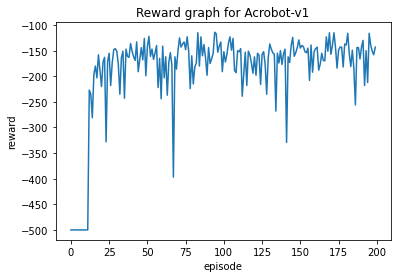

In [14]:
plt.title('Reward graph for Acrobot-v1')
plt.plot(np.arange(len(reward_list[:200])), reward_list[:200])
plt.xlabel('episode')
plt.ylabel('reward')
plt.show()

## Reference
https://github.com/seungeunrho/minimalRL